# Лабораторная работа 3

**Задача**: определить тональность текста по шкале от 1 (негативный) до 10 (позитивный).

**Ввод**: тексты, разделенные переводом строки.

**Вывод**: для каждого текста из входных данных вывести тональную оценку от 1 до 10. Разделитель между выводами для разных текстов —— перевод строки.

In [148]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

In [ ]:
model_name = "cointegrated/rubert-tiny-sentiment-balanced"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [150]:
def classify_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).numpy()[0]
    labels = ['negative', 'neutral', 'positive']
    return labels[np.argmax(probs)], probs

In [ ]:
texts = [
    "Я в полном восторге! Это просто супер!",               
    "Все нормально, без особых эмоций.",                    
    "Отвратительный сервис, больше сюда ни ногой.",         
    "Ну конечно, лучший день в моей жизни — опять опоздал!",
    "Хорошая попытка, но результат ужасен.",                
    "Замечательный фильм, всем советую!",                   
    "Так себе, ожидал большего.",                           
    "Да уж, просто прекрасно сломать всё перед дедлайном."
]

for t in texts:
    label, probs = classify_sentiment(t)
    print(f"Текст: {t}")
    print(f" → Метка: {label}")
    print(f" → Вероятности: {probs}")
    print("-" * 60)

Текст: Я в полном восторге! Это просто супер!
 → Метка: positive
 → Вероятности: [2.0300367e-04 2.8370842e-03 9.9695992e-01]
------------------------------------------------------------
Текст: Все нормально, без особых эмоций.
 → Метка: positive
 → Вероятности: [0.0254467  0.30671644 0.66783684]
------------------------------------------------------------
Текст: Отвратительный сервис, больше сюда ни ногой.
 → Метка: negative
 → Вероятности: [0.9788655  0.01573435 0.00540022]
------------------------------------------------------------
Текст: Ну конечно, лучший день в моей жизни — опять опоздал!
 → Метка: positive
 → Вероятности: [0.10095309 0.02798077 0.8710661 ]
------------------------------------------------------------
Текст: Хорошая попытка, но результат ужасен.
 → Метка: positive
 → Вероятности: [0.1115615  0.31752753 0.570911  ]
------------------------------------------------------------
Текст: Замечательный фильм, всем советую!
 → Метка: positive
 → Вероятности: [2.2841609e-04

In [152]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

api = KaggleApi()
api.authenticate()

# Скачиваем в текущую директорию
api.dataset_download_files('blackmoon/russian-language-toxic-comments', path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments


In [153]:
import pandas as pd

In [154]:
# Загрузка
df = pd.read_csv("labeled.csv")

# Преобразуем toxic: 1 → -1, 0 → 0
df['toxic_adj'] = df['toxic'].apply(lambda x: -1 if x == 1 else 0)

df.head()
df[df['toxic_adj'] == 0]

,comment,toxic,toxic_adj
6,В шапке были ссылки на инфу по текущему фильму...,0.0,0
12,"Почитайте посты у этого автора,может найдете ч...",0.0,0
17,Про графику было обидно) я так то проходил все...,0.0,0
28,https: pp.userapi.com c848520 v848520411 11627...,0.0,0
35,"Возьмём как пример Россию, западноевропейские ...",0.0,0
...,...,...,...
14392,"ТАСС, 21 марта. Премьер-министр Новой Зеландии...",0.0,0
14399,65 А чего так мало? Вот у гражданина был рейти...,0.0,0
14406,Потому что запад прошел эту хуйню еще пару сот...,0.0,0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,0


In [ ]:
def map_model_label(label):
    if label == "positive":
        return 1
    elif label == "negative":
        return -1
    else:  # neutral
        return 0

model_labels = []
for t in df['comment']:
    label, probs = classify_sentiment(t)
    model_labels.append(map_model_label(label))

df['model_label'] = model_labels
df.head()

,comment,toxic,toxic_adj,model_label
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,-1,-1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,-1,-1
2,Собаке - собачья смерть\n,1.0,-1,0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,-1,-1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,-1,0


In [156]:
df['model_label'] = df['model_label'].apply(lambda x: 0 if x == 1 else x)
df

,comment,toxic,toxic_adj,model_label
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,-1,-1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,-1,-1
2,Собаке - собачья смерть\n,1.0,-1,0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,-1,-1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,-1,0
...,...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,-1,-1
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,-1,-1
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,0,-1
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,-1,0


In [ ]:
def check_match(row):
    return row["toxic_adj"] == row["model_label"]

df['match'] = df.apply(check_match, axis=1)

# Метрики
accuracy = df['match'].mean()
print("Совпадение меток модели с toxic:", accuracy)

Совпадение меток модели с toxic: 0.6663197335553706


In [158]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

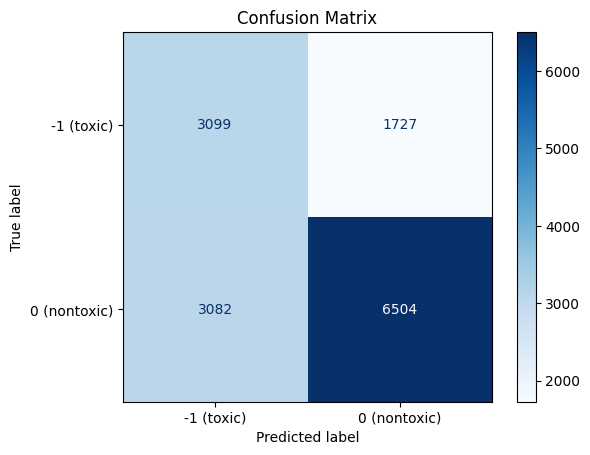

In [ ]:
cm = confusion_matrix(df['toxic_adj'], df['model_label'], labels=[-1, 0])

# Визуализация
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1 (toxic)', '0 (nontoxic)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Дообучаем модель (устарело, вместо этого дообучаем на сарказм)

In [ ]:
import torch

# df['toxic_adj'] = -1 или 0
# Метки для модели (0=negative, 1=neutral, 2=positive)
def label_for_training(toxic_adj, original_label=None):
    if toxic_adj == -1:
        return 0  # negative
    else:
        return 1 if original_label == 1 else 2

df['train_label'] = df.apply(lambda row: label_for_training(row['toxic_adj'], map_model_label(classify_sentiment(row['comment'])[0])), axis=1)

In [78]:
from torch.utils.data import Dataset

encodings = tokenizer(list(df['comment']), truncation=True, padding=True, max_length=128)
labels = torch.tensor(df['train_label'].values)

class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

dataset = CommentDataset(encodings, labels)

In [79]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy="epoch",
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

In [80]:
trainer.train()

Step,Training Loss
50,1.285600
100,0.767700
150,0.670100
200,0.608200
250,0.624800
300,0.536600
350,0.565300
400,0.538900
450,0.538800
500,0.499800


TrainOutput(global_step=2703, training_loss=0.4284580605937691, metrics={'train_runtime': 302.03, 'train_samples_per_second': 143.151, 'train_steps_per_second': 8.949, 'total_flos': 79718196446208.0, 'train_loss': 0.4284580605937691, 'epoch': 3.0})

Совпадение меток дообученной модели с toxic: 0.9190258118234804


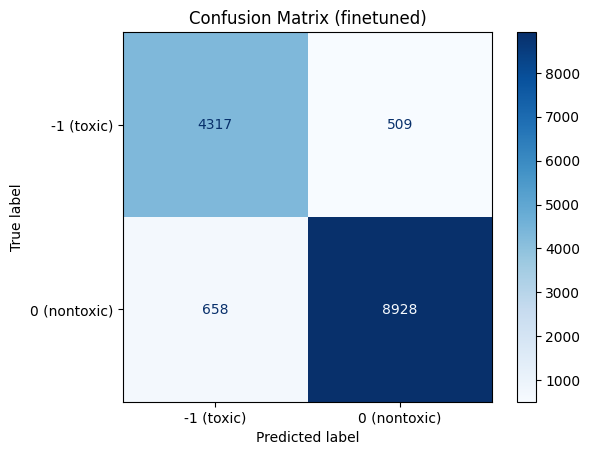

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = trainer.model
model.to(device)
model.eval()

def classify_sentiment_finetuned(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    labels = ['negative', 'neutral', 'positive']  # 0,1,2
    return labels[np.argmax(probs)], probs

def map_model_label(label):
    if label == "positive":
        return 1
    elif label == "negative":
        return -1
    else:  # neutral
        return 0

model_labels = []
for t in df['comment']:
    label, probs = classify_sentiment_finetuned(t)
    model_labels.append(map_model_label(label))

df['model_label'] = model_labels

df['model_label'] = df['model_label'].apply(lambda x: 0 if x == 1 else x)

def check_match(row):
    return row["toxic_adj"] == row["model_label"]

df['match'] = df.apply(check_match, axis=1)

accuracy = df['match'].mean()
print("Совпадение меток дообученной модели с toxic:", accuracy)

cm = confusion_matrix(df['toxic_adj'], df['model_label'], labels=[-1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1 (toxic)', '0 (nontoxic)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (finetuned)")
plt.show()

In [ ]:
texts = [
    "Я в полном восторге! Это просто супер!",               
    "Все нормально, без особых эмоций.",                    
    "Отвратительный сервис, больше сюда ни ногой.",         
    "Ну конечно, лучший день в моей жизни — опять опоздал!",
    "Хорошая попытка, но результат ужасен.",                
    "Замечательный фильм, всем советую!",                   
    "Так себе, ожидал большего.",                           
    "Да уж, просто прекрасно сломать всё перед дедлайном." 
]

for t in texts:
    label, probs = classify_sentiment_finetuned(t)
    print(f"Текст: {t}")
    print(f" → Метка: {label}")
    print(f" → Вероятности: {probs}")
    print("-" * 60)

Текст: Я в полном восторге! Это просто супер!
 → Метка: neutral
 → Вероятности: [0.00174178 0.9922462  0.00601203]
------------------------------------------------------------
Текст: Все нормально, без особых эмоций.
 → Метка: neutral
 → Вероятности: [0.03902399 0.73099923 0.22997682]
------------------------------------------------------------
Текст: Отвратительный сервис, больше сюда ни ногой.
 → Метка: negative
 → Вероятности: [9.7344625e-01 3.4121171e-04 2.6212510e-02]
------------------------------------------------------------
Текст: Ну конечно, лучший день в моей жизни — опять опоздал!
 → Метка: neutral
 → Вероятности: [0.03444962 0.8988126  0.06673778]
------------------------------------------------------------
Текст: Хорошая попытка, но результат ужасен.
 → Метка: neutral
 → Вероятности: [0.20486379 0.44668508 0.34845123]
------------------------------------------------------------
Текст: Замечательный фильм, всем советую!
 → Метка: neutral
 → Вероятности: [0.00183745 0.98158

## Дообучаем на сарказм

In [177]:
api.dataset_download_files('danofer/sarcasm', path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/danofer/sarcasm


In [ ]:
df = pd.read_csv('train-balanced-sarcasm.csv')
#df = df[:1000]
df = df[['label', 'comment']]

N = 500
df_0 = df[df['label'] == 0].head(N)
df_1 = df[df['label'] == 1].head(N)

df_sample = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)
df_sample['label'].value_counts()

In [ ]:
df_sample.isna().sum() 

label      0
comment    0
dtype: int64

In [ ]:
df_sample.dropna(inplace=True) 
df_sample.isna().sum()

label      0
comment    0
dtype: int64

In [ ]:
from deep_translator import GoogleTranslator
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

In [ ]:
# Перевод комментариев
df_sample['comment_ru'] = df_sample['comment'].progress_apply(
    lambda x: GoogleTranslator(source='en', target='ru').translate(x)
)

100%|██████████| 1000/1000 [11:55<00:00,  1.40it/s]


In [ ]:
df_sample.to_csv('sarcasm_translated.csv', index=False)

In [ ]:
df_sample = pd.read_csv('sarcasm_translated.csv')

In [ ]:
df_sample = df_sample.dropna(subset=['comment_ru'])
df_sample['comment_ru'] = df_sample['comment_ru'].astype(str)
print(df_sample['comment_ru'].head())
print(len(df_sample['comment_ru']))


0    БЕЛЫЙ МУЖЧИНА хочет уничтожить двух сильных, н...
1    Должно быть, тяжело жить, будучи таким чертовс...
2                              Я бы предпочел Рэшфорда
3    Киллари Шиллтон, очевидно, контролирует вас, и...
4                                    Обязательное Сато
Name: comment_ru, dtype: object
999


In [ ]:
df_sample

,label,comment,comment_ru,train_label,pred_label
0,1,A WHITE FUCKIN MALE is out to destroy 2 strong...,"БЕЛЫЙ МУЖЧИНА хочет уничтожить двух сильных, н...",1,0
1,1,Must be hard living life being so damn tall,"Должно быть, тяжело жить, будучи таким чертовс...",1,0
2,1,Id rather have Rashford,Я бы предпочел Рэшфорда,1,0
3,1,Killary Shillton must obviously be controlling...,"Киллари Шиллтон, очевидно, контролирует вас, и...",1,0
4,0,Obligatory Satou,Обязательное Сато,0,1
...,...,...,...,...,...
995,0,Grab a coat for these patriots!,Возьмите пальто для этих патриотов!,0,0
996,0,You can put your weed in there,Вы можете положить туда свою травку,0,1
997,1,Man I love tinkle down economics!,"Чувак, я обожаю экономию!",1,0
998,0,Is it bad that I've never gotten a sextuple kill?,"Разве плохо, что мне ни разу не удалось соверш...",0,1


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments


df_sample['train_label'] = df_sample['label'].apply(lambda x: 0 if x == 0 else 1)

encodings = tokenizer(
    df_sample['comment_ru'].tolist(),  # обязательно .tolist()
    truncation=True,
    padding=True,
    max_length=128
)

labels = torch.tensor(df_sample['train_label'].values)

class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

dataset = CommentDataset(encodings, labels)

training_args = TrainingArguments(
    output_dir='./results_sarcasm',
    num_train_epochs=30,          
    per_device_train_batch_size=32,
    learning_rate=1e-5,          # меньше, чтобы не "забыть" старое
    logging_dir='./logs_sarcasm',
    logging_steps=50,
    save_strategy="epoch",
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,                 
    args=training_args,
    train_dataset=dataset
)

In [ ]:
trainer.train()

Step,Training Loss
50,1.127600
100,0.749700
150,0.667300
200,0.645700
250,0.625200
300,0.581600
350,0.579200
400,0.548600
450,0.530900
500,0.507900


TrainOutput(global_step=960, training_loss=0.5593113695581754, metrics={'train_runtime': 182.2943, 'train_samples_per_second': 164.405, 'train_steps_per_second': 5.266, 'total_flos': 55258450076160.0, 'train_loss': 0.5593113695581754, 'epoch': 30.0})

In [ ]:
# Сохраняем модель
trainer.save_model("./results_sarcasm_final")
tokenizer.save_pretrained("./results_sarcasm_final")

('./results_sarcasm_final/tokenizer_config.json',
 './results_sarcasm_final/special_tokens_map.json',
 './results_sarcasm_final/vocab.txt',
 './results_sarcasm_final/added_tokens.json',
 './results_sarcasm_final/tokenizer.json')

Accuracy на обучающем (сарказм) датасете: 0.8398


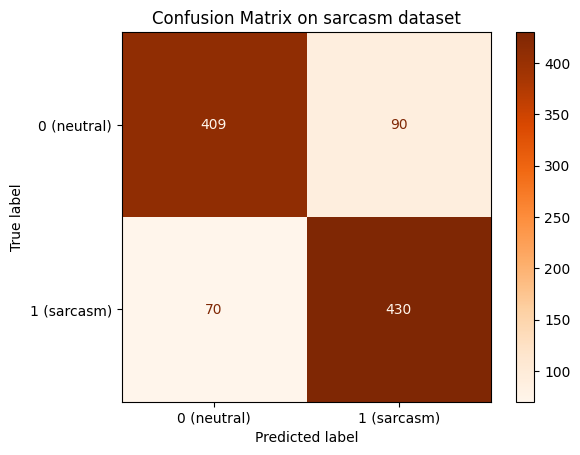

In [243]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pred_labels = []

for text in df_sample['comment_ru']:
    label, probs = classify_sentiment_finetuned(text)
    pred_labels.append(label)

pred_numeric = [0 if lbl == 'negative' else 1 for lbl in pred_labels]

df_sample['pred_label'] = pred_numeric

accuracy = accuracy_score(df_sample['label'], df_sample['pred_label'])
print(f"Accuracy на обучающем (сарказм) датасете: {accuracy:.4f}")

cm = confusion_matrix(df_sample['label'], df_sample['pred_label'], labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0 (neutral)', '1 (sarcasm)'])
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix on sarcasm dataset")
plt.show()


In [ ]:
texts = [
    "Я в полном восторге! Это просто супер!",               
    "Это было хорошо и я рад",
    "Все нормально, без особых эмоций.",                    
    "Отвратительный сервис, больше сюда ни ногой.",         
    "Ну конечно, лучший день в моей жизни — опять опоздал!",
    "Хорошая попытка, но результат ужасен.",                
    "Замечательный фильм, всем советую!",                   
    "Так себе, ожидал большего.",                          
    "Да уж, просто прекрасно сломать всё перед дедлайном." 
]

for t in texts:
    label, probs = classify_sentiment_finetuned(t)
    print(f"Текст: {t}")
    print(f" → Метка: {label}")
    print(f" → Вероятности: {probs}")
    print("-" * 60)

Текст: Я в полном восторге! Это просто супер!
 → Метка: neutral
 → Вероятности: [0.27983725 0.7015972  0.01856549]
------------------------------------------------------------
Текст: Это было хорошо и я рад
 → Метка: neutral
 → Вероятности: [0.11582628 0.77705294 0.10712079]
------------------------------------------------------------
Текст: Все нормально, без особых эмоций.
 → Метка: neutral
 → Вероятности: [0.38415182 0.61322194 0.00262626]
------------------------------------------------------------
Текст: Отвратительный сервис, больше сюда ни ногой.
 → Метка: negative
 → Вероятности: [0.90341896 0.09517545 0.0014056 ]
------------------------------------------------------------
Текст: Ну конечно, лучший день в моей жизни — опять опоздал!
 → Метка: neutral
 → Вероятности: [0.4566879  0.5243885  0.01892363]
------------------------------------------------------------
Текст: Хорошая попытка, но результат ужасен.
 → Метка: neutral
 → Вероятности: [0.3056988  0.6905437  0.00375752]
----

## Научим определяться по знакам препинания

In [ ]:
finetune_texts = [
    # -------------------- позитивные --------------------
    ("Я в полном восторге! Это супер!", 2),
    ("Отличная работа команды!", 2),
    ("Наконец-то всё получилось!", 2),
    ("Замечательный день!", 2),
    ("Очень рад результату!", 2),
    ("Это было просто великолепно!", 2),
    ("Я в восторге от этого!", 2),
    ("Лучше не бывает!", 2),
    ("Спасибо за такой прекрасный опыт!", 2),
    ("Все идеально!", 2),
    ("Потрясающий фильм!", 2),
    ("Сервис на высшем уровне!", 2),
    ("Абсолютно доволен!", 2),
    ("Прекрасная идея!", 2),
    ("Всё прошло отлично!", 2),
    # -------------------- нейтральные --------------------
    ("Всё нормально, без эмоций.", 1),
    ("Работа выполнена как обычно.", 1),
    ("Ничего особенного.", 1),
    ("Средний результат.", 1),
    ("Так себе день.", 1),
    ("Не могу сказать ничего нового.", 1),
    ("Просто обычный комментарий.", 1),
    ("Обычная ситуация.", 1),
    ("Это ожидаемо.", 1),
    ("Ничего хорошего и плохого.", 1),
    ("Среднестатистический опыт.", 1),
    ("Просто факт.", 1),
    ("Повседневная ситуация.", 1),
    ("Обычный пост.", 1),
    ("Нейтрально.", 1),
    # -------------------- сарказм/негатив --------------------
    ("Ну конечно, лучший день в моей жизни — опять опоздал...", 0),
    ("Отлично, ещё одна встреча отменена!", 0),
    ("Просто супер, сервер упал перед дедлайном...", 0),
    ("Замечательно, опоздал на автобус.", 0),
    ("Ну да, всё по плану, а кот сломал проект...", 0),
    ("Прекрасно, никто не прислушался к советам...", 0),
    ("Снова всё ужасно, как всегда...", 0),
    ("Фантастика, всё идёт наперекосяк...", 0),
    ("Просто идеально, а никто не помог...", 0),
    ("Да уж, счастье полное...", 0),
    ("Ух ты, теперь ещё больше проблем...", 0),
    ("Великолепно, всё сломалось в самый важный момент...", 0),
    ("Отлично, никто не сделал свою часть работы...", 0),
    ("Прекрасно, мне снова придётся переделывать всё...", 0),
    ("Ну а как иначе? Всё идёт наперекосяк...", 0),
        # === Положительные (2) ===
    ("Я просто в восторге от этой функции!", 2),
    ("Как здорово, что всё работает идеально!", 2),
    ("Наконец-то увидел результат своей работы!", 2),
    ("Это было очень полезно!", 2),
    ("Отличная идея!", 2),
    ("Очень понравился подход!", 2),
    ("Приятно удивлён результатом!", 2),
    ("Все прошло отлично!", 2),
    ("Это намного лучше, чем я ожидал!", 2),
    ("Сервис превзошёл мои ожидания!", 2),
    ("Замечательная работа команды!", 2),
    ("Всё сделано очень аккуратно!", 2),
    ("Я доволен качеством!", 2),
    ("Прекрасное обслуживание!", 2),
    ("Все супер, без проблем!", 2),
    ("Очень комфортно пользоваться!", 2),
    ("Я в восторге от дизайна!", 2),
    ("Результат просто шикарный!", 2),
    ("Отличная поддержка!", 2),
    ("Все было организовано прекрасно!", 2),
    
    # === Нейтральные (1) ===
    ("Всё прошло как обычно.", 1),
    ("Ничего особенного сегодня.", 1),
    ("Средний опыт, ничего нового.", 1),
    ("Работа выполнена стандартно.", 1),
    ("День обычный, без изменений.", 1),
    ("Результат стандартный.", 1),
    ("Просто обычная ситуация.", 1),
    ("Все как обычно.", 1),
    ("Никаких эмоций.", 1),
    ("Средний уровень сервиса.", 1),
    ("Ничего нового не произошло.", 1),
    ("Все стандартно.", 1),
    ("Обычная реакция.", 1),
    ("Средний день.", 1),
    ("Нормально, ничего особенного.", 1),
    ("Прошло без изменений.", 1),
    ("Ничего нового.", 1),
    ("Стандартная работа.", 1),
    ("Все как всегда.", 1),
    ("Среднестатистическая ситуация.", 1),
    
    # === Негативные/сарказм (0) ===
    ("Ну конечно, снова опоздание!", 0),
    ("Прекрасно, сломался компьютер...", 0),
    ("Да уж, всё пошло не так.", 0),
    ("Отлично, снова ошибки в отчётах.", 0),
    ("Фантастика, забыли все инструкции!", 0),
    ("Прекрасно, никто не слушает!", 0),
    ("Как всегда, всё ужасно.", 0),
    ("Снова всё пошло не так.", 0),
    ("Да уж, кто-то испортил работу.", 0),
    ("Прекрасно, опять сбой системы!", 0),
    ("Ну конечно, как обычно...", 0),
    ("Фантастика, всё испорчено снова.", 0),
    ("Да уж, полный хаос.", 0),
    ("Прекрасно, никто не помог.", 0),
    ("Снова всё плохо организовано.", 0),
    ("Ну конечно, ожидал лучшего.", 0),
    ("Супер, опять провал.", 0),
    ("Да уж, счастливого дня не получилось.", 0),
    ("Просто идеально, ошибки повсюду.", 0),
    ("Замечательно, кто-то испортил результат.", 0)
]

extended_texts = []
for i in range(15):  # 15*100 ~ 300 текстов
    for t, l in finetune_texts: 
        new_text = t.replace("!", "!" if i % 2 == 0 else ".").replace("снова", "опять" if i % 3 == 0 else "ещё раз")
        extended_texts.append((new_text, l))

texts_300, labels_300 = zip(*extended_texts)


In [229]:
texts, labels = zip(*finetune_texts)
labels = torch.tensor(labels)

# --- Кодирование через токенизатор ---
encodings = tokenizer(
    list(texts),
    truncation=True,
    padding=True,
    max_length=128
)

# --- Dataset для Trainer ---
class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

dataset = CommentDataset(encodings, labels)

# --- TrainingArguments ---
training_args = TrainingArguments(
    output_dir='./results_finetune',
    num_train_epochs=5,          # достаточно 1–2 эпох для "подстройки"
    per_device_train_batch_size=8, # маленький batch, мало данных
    learning_rate=1e-5,          # маленький lr, чтобы не "забыть" старое
    logging_dir='./logs_finetune',
    logging_steps=10,
    save_strategy="epoch",
    dataloader_pin_memory=False
)

# --- Trainer ---
trainer = Trainer(
    model=model,   # используем уже загруженную модель
    args=training_args,
    train_dataset=dataset
)

# --- Дообучение ---
trainer.train()

Step,Training Loss
10,1.509700
20,1.350200
30,0.823700
40,0.773500
50,0.915500
60,0.702400
70,0.623500


TrainOutput(global_step=70, training_loss=0.9569362708500453, metrics={'train_runtime': 6.0746, 'train_samples_per_second': 86.426, 'train_steps_per_second': 11.523, 'total_flos': 189060716250.0, 'train_loss': 0.9569362708500453, 'epoch': 5.0})

Наконец, надо научить модель распознавать классы от 1 до 10

In [230]:
model.eval()

def predict_tone(texts):
    scores = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()[0]

        tone = probs[0]*1 + probs[1]*5 + probs[2]*10
        tone = int(np.round(tone, 0)) 
        scores.append(tone)

    return scores

In [231]:
texts = [
    # Положительные
    "Я в полном восторге! Это супер!",
    "Очень хорошая работа, доволен результатом!",
    "Как же приятно получить такой подарок!",
    "Замечательно, всё получилось идеально!",
    "Отлично, спасибо за помощь!",
    "Просто прекрасно, настроение поднялось.",
    "Я в восторге, рекомендую всем!",

    # Нейтральные
    "Сходил поплавал, потом посмотрел кино",
    "Всё прошло как обычно, ничего нового",
    "Неплохо, но можно лучше",
    "Это средне, ни плохо, ни хорошо",
    "Всё отлично, я доволен результатом",
    "Ничего особенного, как всегда",

    # Сарказм / негатив
    "Ну вот, опять всё испортили.",
    "Слишком медленно, ждать невозможно.",
    "Совсем не смешно, ожидал больше юмора.",
    "Ужасно, не хочу сюда возвращаться.",
    "Снова подвели, разочарован.",
    "Не понравилось, слишком много ошибок.",
    "Да уж, просто прекрасно сломать всё перед дедлайном."
]


tones = predict_tone(texts)
for t, s in zip(texts, tones):
    print(f"{t} → {s}")

Я в полном восторге! Это супер! → 10
Очень хорошая работа, доволен результатом! → 8
Как же приятно получить такой подарок! → 7
Замечательно, всё получилось идеально! → 10
Отлично, спасибо за помощь! → 10
Просто прекрасно, настроение поднялось. → 5
Я в восторге, рекомендую всем! → 10
Сходил поплавал, потом посмотрел кино → 2
Всё прошло как обычно, ничего нового → 3
Неплохо, но можно лучше → 4
Это средне, ни плохо, ни хорошо → 4
Всё отлично, я доволен результатом → 9
Ничего особенного, как всегда → 4
Ну вот, опять всё испортили. → 2
Слишком медленно, ждать невозможно. → 3
Совсем не смешно, ожидал больше юмора. → 3
Ужасно, не хочу сюда возвращаться. → 2
Снова подвели, разочарован. → 3
Не понравилось, слишком много ошибок. → 3
Да уж, просто прекрасно сломать всё перед дедлайном. → 3


In [242]:
texts = [
    "Как же приятно получить такой подарок!",
    "Как же приятно получить такой подарок",
    "Как же приятно получить такой подарок..."    
]


tones = predict_tone(texts)
for t, s in zip(texts, tones):
    print(f"{t} → {s}")

Как же приятно получить такой подарок! → 7
Как же приятно получить такой подарок → 3
Как же приятно получить такой подарок... → 2
